# Feature Analysis of Riot Match Data
Goals of this notebook are to;
1. Determine which features are important
2. Make selections of various features which will be used to train a classification model

In [6]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore')

In [7]:
# pulling data from the pseudo datahub

parent_directory = os.getcwd()
sub_directory = 'datahub\\access\match_dataset.csv'

df = pd.read_csv(os.path.join(parent_directory, sub_directory))

# Analysis of feature types
Determine the following;
1. Do the feature types make sense
2. Which features go into which feature selection analysis

In [8]:
# determine data types for feature analysis
df_types = pd.DataFrame(df.dtypes[1:]).reset_index().rename(columns = {'index':'feature', 0:'feature_type'})
target_feature = ['match_team_win']
numeric_feature = list(df_types[df_types.feature_type == 'float64']['feature'])
categorical_feature = list(df_types[df_types.feature_type == 'int64']['feature'])
categorical_feature.remove('match_team_win')

# Feature Sorting
1. Sort the features into different variables for training/testing/targetting
2. Split the dataset into training and test results

In [9]:
X = df[numeric_feature + categorical_feature]
y = df[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.8, random_state=1)

# Feature Investigation
1. Determine if numeric variables are correlated to each other. If highly correlated, remove them, as this could indicate multi-variable dependency, which could provide a stronger signal than intended.
2. Analyse the importance of variables for both numeric and categorical. Numeric will be done with Anova and Categorical will be done with Chi2

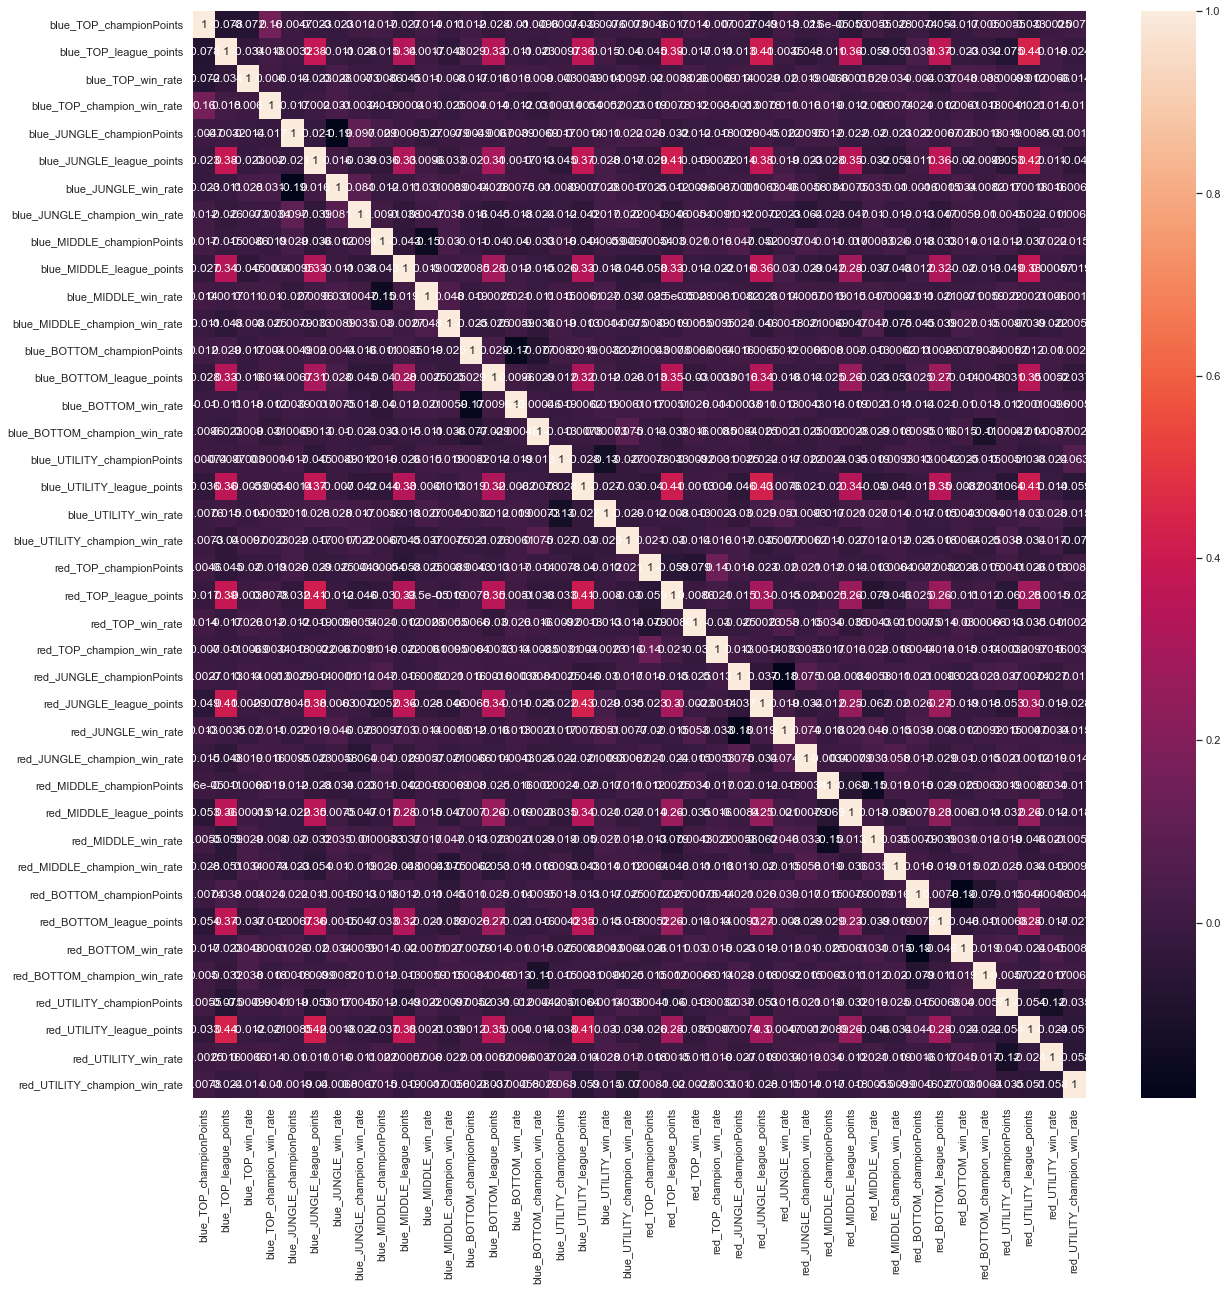

In [10]:
# investigate if any numeric variables are highly correlated. 
sns.set(rc = {'figure.figsize':(20,20)})
corrMatrix = X_test[numeric_feature].corr()
sns.heatmap(corrMatrix,annot=True)

##### Seems like the majority of variable-to-variable correlations are little-none, with the exception of league_points (low-medium) which has around 0.3-0.4 (although not strong enough to remove). This makes sense since we are analysing high MMR gameplay, and thus we expect a 'stronger' relationship compared to other variables.

# Numeric Feature Analysis

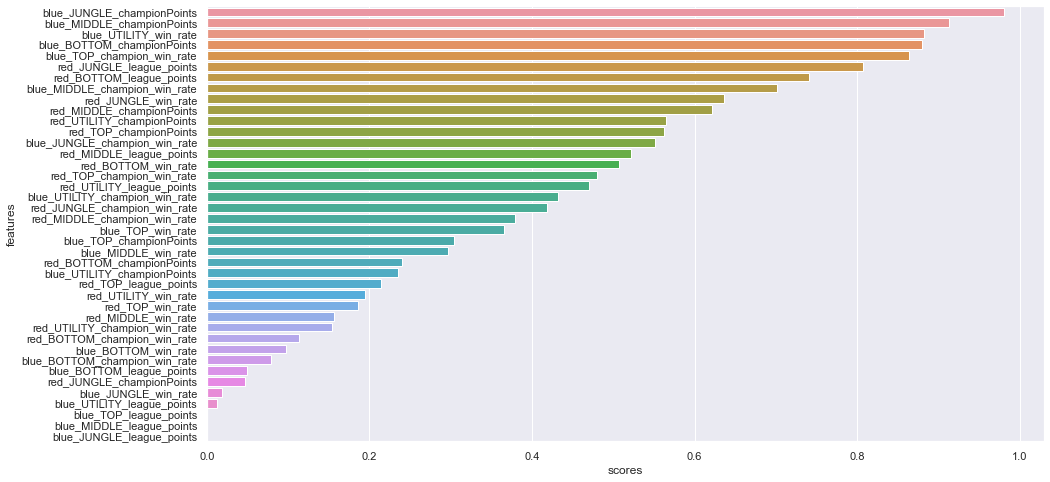

In [11]:
nvalue = SelectKBest(f_classif, k='all')
nvalue = nvalue.fit(X_train[numeric_feature], y_train)
numeric_feature_analysis = pd.DataFrame(data = {'features':numeric_feature, 'scores':nvalue.pvalues_}).sort_values(by = 'scores', ascending = False)
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x = numeric_feature_analysis['scores'], y = numeric_feature_analysis['features'])

# Feature Discussion
## Numeric
1. League Points seem to be strong variables of independency. This makes sense, as higher league points means greater mastery and competitiveness of matches. Suggestion should be to take all league_point variables (including red_TOP_league_points which sits 2nd last, as the inverse analysis for red would lead to red favoured results) as theoretically, greater competency leads to better match results.
2. Champion Win Rates also seem good, which from domain expertise, can influence matches heavily, as overtuned or undertuned champions impact games greatly. e.g. Overtuned champions can dominate matches as they are considered 'broken' whilst undertuned can be outmatched by 'standard' picks
3. Position Win Rates also seems good, which makes sense, as higher winrates in roles with a champion, signal that a player is highly skilled with that champion. This allows them to pull higher winrates, and thus achieve more league points and climb faster (as competition is weaker).
4. Champion Points, seems to have small impact on match outcomes, which the vast majority are clustered in the lower-half of the above chart. This could be explained by the following. 4.1 Champion mastery is really a KPI for gameplay time on a champion, and not really expertise. This is evident in lower MMRs, where players can have many hours in a champion, but not necessarily higher MMR skills, as the quality of the game can be more important than quantity.
4.2 There is cap on how much a player can learn by gameplay hours, as theoretically at an underdetermined point the experience gained would taper off drastically.Current suggestion is to exclude champion point features.


# Categorical Feature Analysis

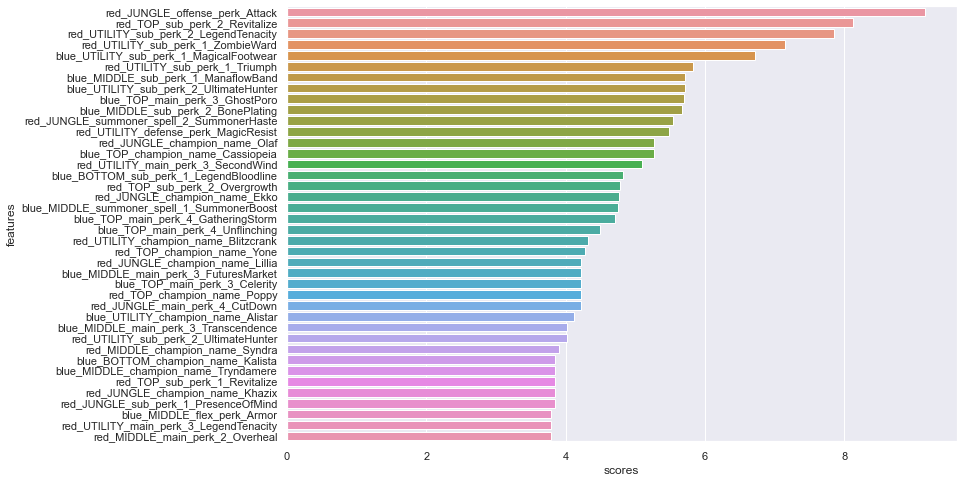

In [12]:
cvalue = SelectKBest(chi2, k='all')
cvalue = cvalue.fit(X_train[categorical_feature], y_train)
categorical_feature_analysis = pd.DataFrame(data = {'features':categorical_feature, 'scores':cvalue.scores_}).sort_values(by = 'scores', ascending = False)

sns.set(rc = {'figure.figsize':(12,8)})

# displaying top 40 results for now, due to image constraints
sns.barplot(x = categorical_feature_analysis['scores'].iloc[:40], y = categorical_feature_analysis['features'].iloc[:40])

# Feature Discussion
## Categorical
Results have been extracted out to a CSV for further observations (as there are many results).

1. 75% of Offense/Defense/Flex perks-role combinations sit below 1 and 44% sitting below 0.1 with the exception of red_jungle_offense_perk_attack. This suggests these variables have dependency on the win results due to the low variation. This can be explained for a few reasons 1.1 Limited choice in these perks (9 in total with 3 required for selection) 1.2 Significant overlap in perk choice selection 1.3 Generally these perks are a one size fits all case for any match, and have little to no effect on matchup. 1.4 In the case where there is greater dependency of results such as red_JUNGLE_offense_perk_attack (top 4 result), this can be explained as this is a very common perk used by the majority of jungle roles, and thus are highly used by both red and blue teams (thus reduces dependency of match outcomes as the perks become more equally distributed). Suggestion is to remove all offense/defense/flex perk-role combination features
2. 70% of position hotstreak combinations sit below 0.7. This suggest these variables have dependency on the win results. However, these should be removed, as hotstreak is the amalgamation of previous match results achieved by a team, not necesarily the player themselves. But, in lower MMR it could be a predictive feature as games are more influenced by a single player.
3. The remaining features seem okay, although results do vary significantly. The reason for this is, lower results like red_UTILITY_champion_name_Riven and red_UTILITY_champion_name_LeeSin are very rare combinations (although not unheard of) which typically wouldn't be found in matches, as champions like Riven/LeeSin are mainly found in Top/Jungle. Due to this rarity and small amount of games, the outcome of the Chi2 results is skewed (lower games played = lower variation = seemingly greater dependency). These results could be excluded now, however, let's take this into the model training, then iterate over it to remove features from lowest ranking to highest.

In [13]:
# Features to remove per the above recommendations
numeric_features_remove = ['blue_TOP_championPoints',
                           'blue_JUNGLE_championPoints',
                           'blue_MIDDLE_championPoints',
                           'blue_BOTTOM_championPoints',
                           'blue_UTILITY_championPoints',
                           'red_TOP_championPoints',
                           'red_JUNGLE_championPoints',
                           'red_MIDDLE_championPoints',
                           'red_BOTTOM_championPoints',
                           'red_UTILITY_championPoints']

categorical_features_remove = ['red_JUNGLE_offense_perk_Attack',
                                'blue_BOTTOM_hotstreak',
                                'blue_BOTTOM_flex_perk_MagicResist',
                                'blue_JUNGLE_offense_perk_Attack',
                                'blue_MIDDLE_offense_perk_CooldownReduction',
                                'red_TOP_flex_perk_Armor',
                                'blue_BOTTOM_flex_perk_Armor',
                                'blue_JUNGLE_flex_perk_MagicResist',
                                'blue_TOP_defense_perk_Health',
                                'blue_JUNGLE_defense_perk_Health',
                                'blue_TOP_flex_perk_MagicResist',
                                'red_BOTTOM_defense_perk_Health',
                                'red_UTILITY_flex_perk_MagicResist',
                                'blue_UTILITY_hotstreak',
                                'blue_BOTTOM_offense_perk_CooldownReduction',
                                'red_TOP_defense_perk_Health',
                                'blue_TOP_defense_perk_MagicResist',
                                'red_UTILITY_defense_perk_Health',
                                'red_JUNGLE_offense_perk_AttackSpeed',
                                'blue_MIDDLE_defense_perk_Health',
                                'blue_MIDDLE_hotstreak',
                                'red_BOTTOM_flex_perk_MagicResist',
                                'blue_BOTTOM_defense_perk_MagicResist',
                                'blue_MIDDLE_flex_perk_Armor',
                                'blue_UTILITY_offense_perk_CooldownReduction',
                                'red_UTILITY_hotstreak',
                                'red_UTILITY_flex_perk_Attack',
                                'red_BOTTOM_defense_perk_MagicResist',
                                'red_JUNGLE_defense_perk_MagicResist',
                                'red_MIDDLE_offense_perk_Attack',
                                'blue_JUNGLE_offense_perk_AttackSpeed',
                                'red_BOTTOM_offense_perk_CooldownReduction',
                                'blue_BOTTOM_offense_perk_Attack',
                                'red_UTILITY_offense_perk_AttackSpeed',
                                'blue_TOP_hotstreak',
                                'red_UTILITY_offense_perk_Attack',
                                'blue_UTILITY_flex_perk_Armor',
                                'red_MIDDLE_offense_perk_AttackSpeed',
                                'red_JUNGLE_hotstreak',
                                'blue_TOP_flex_perk_Armor',
                                'blue_JUNGLE_hotstreak',
                                'blue_TOP_offense_perk_Attack',
                                'blue_UTILITY_offense_perk_Attack',
                                'red_UTILITY_flex_perk_Armor',
                                'red_TOP_defense_perk_Armor',
                                'red_BOTTOM_offense_perk_Attack',
                                'blue_TOP_offense_perk_AttackSpeed',
                                'red_TOP_defense_perk_MagicResist',
                                'red_MIDDLE_offense_perk_CooldownReduction',
                                'red_UTILITY_offense_perk_CooldownReduction',
                                'blue_JUNGLE_offense_perk_CooldownReduction',
                                'red_MIDDLE_hotstreak',
                                'red_TOP_offense_perk_Attack',
                                'red_TOP_offense_perk_AttackSpeed',
                                'red_BOTTOM_offense_perk_AttackSpeed',
                                'red_JUNGLE_offense_perk_CooldownReduction',
                                'red_TOP_flex_perk_Attack',
                                'blue_UTILITY_flex_perk_Attack',
                                'red_TOP_offense_perk_CooldownReduction',
                                'blue_UTILITY_defense_perk_Health',
                                'blue_TOP_defense_perk_Armor',
                                'red_JUNGLE_flex_perk_Armor',
                                'red_JUNGLE_defense_perk_Armor',
                                'red_BOTTOM_defense_perk_Armor',
                                'blue_BOTTOM_defense_perk_Armor',
                                'blue_MIDDLE_offense_perk_Attack',
                                'red_MIDDLE_flex_perk_MagicResist',
                                'red_MIDDLE_defense_perk_Health',
                                'red_TOP_hotstreak',
                                'red_MIDDLE_flex_perk_Armor',
                                'blue_TOP_flex_perk_Attack',
                                'red_UTILITY_defense_perk_MagicResist',
                                'blue_BOTTOM_offense_perk_AttackSpeed',
                                'blue_JUNGLE_flex_perk_Armor',
                                'blue_JUNGLE_defense_perk_Armor',
                                'blue_TOP_offense_perk_CooldownReduction',
                                'red_BOTTOM_hotstreak',
                                'blue_UTILITY_defense_perk_MagicResist',
                                'blue_MIDDLE_defense_perk_MagicResist',
                                'blue_UTILITY_defense_perk_Armor',
                                'red_JUNGLE_defense_perk_Health',
                                'red_UTILITY_defense_perk_Armor',
                                'blue_MIDDLE_offense_perk_AttackSpeed',
                                'blue_MIDDLE_defense_perk_Armor',
                                'blue_BOTTOM_flex_perk_Attack',
                                'blue_MIDDLE_flex_perk_Attack',
                                'blue_JUNGLE_defense_perk_MagicResist',
                                'blue_UTILITY_flex_perk_MagicResist',
                                'red_MIDDLE_defense_perk_Armor',
                                'red_MIDDLE_defense_perk_MagicResist',
                                'blue_UTILITY_offense_perk_AttackSpeed',
                                'red_JUNGLE_flex_perk_Attack',
                                'red_BOTTOM_flex_perk_Attack',
                                'blue_JUNGLE_flex_perk_Attack',
                                'red_TOP_flex_perk_MagicResist',
                                'blue_BOTTOM_defense_perk_Health',
                                'blue_MIDDLE_flex_perk_MagicResist',
                                'red_MIDDLE_flex_perk_Attack',
                                'red_BOTTOM_flex_perk_Armor']

# Creating new list of features to be used
numeric_features_keep = [ x for x in numeric_feature if x not in numeric_features_remove]
categorical_features_keep = [ x for x in categorical_feature if x not in categorical_features_remove]
features_keep = numeric_features_keep + categorical_features_keep

# Model Selection & Evaluation

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Models
The below models have been selected as they are commonly used classifications techniques

In [15]:
# defining models to use
models = {}
models['Logistic Regression'] = LogisticRegression()
models['Support Vector Machines'] = LinearSVC()
models['Decision Trees'] = DecisionTreeClassifier()
models['Random Forest'] = RandomForestClassifier()
models['Naive Bayes'] = GaussianNB()
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [16]:
# evaluating model types
for key in models.keys():
    models[key].fit(X_train[features_keep], y_train)
    y_pred = models[key].predict(X_test[features_keep])
    score = metrics.accuracy_score(y_test, y_pred)
    print(f'{key}:\t Accuracy:{score}')

Logistic Regression:	 Accuracy:0.5382479171926281
Support Vector Machines:	 Accuracy:0.5342085331986872
Decision Trees:	 Accuracy:0.5190608432214088
Random Forest:	 Accuracy:0.5364806866952789
Naive Bayes:	 Accuracy:0.49255238576117144
K-Nearest Neighbor:	 Accuracy:0.5066902297399647


##### Results produced don't seem to be that good as they are 'just' better than a coinflip. However, Logistic Regression does seem best out of these models. Let see if we can improve these results with the Logistic Regression Model by reducing Categorical Features from Worst to Best Chi2 Scores.

# Model Tuning with Feature Ranking Selection for Categorical
Purpose of the below is to remove the worst features provided by the chi2, and see which features provide the highest accuracy.

In [17]:
# inverse list from worst rank to best rank
categorical_features_ranks = [x for x in categorical_feature_analysis['features'] if x in categorical_features_keep][::-1]

features_evaluate_1 = features_keep.copy()
features_best_1 = list()

# generates an accuracy score based on feature by removing the worst ones from chi2 iteratively
for i, features_rank in enumerate(categorical_features_ranks):
    features_evaluate_1.remove(features_rank)
    models['Logistic Regression'].fit(X_train[features_evaluate_1], y_train)
    y_pred = models['Logistic Regression'].predict(X_test[features_evaluate_1])
    score = metrics.accuracy_score(y_test, y_pred)
    model_analysis = {'Iteration':i, 'Accuracy':score, 'Feature List': features_evaluate_1}
    features_best_1.append(model_analysis)
    print(f'Iteration: {i} \t Accuracy:{score}')

Iteration: 0 	 Accuracy:0.5390053016914921
Iteration: 1 	 Accuracy:0.5390053016914921
Iteration: 2 	 Accuracy:0.5374905326937642
Iteration: 3 	 Accuracy:0.5382479171926281
Iteration: 4 	 Accuracy:0.5379954556930068
Iteration: 5 	 Accuracy:0.5382479171926281
Iteration: 6 	 Accuracy:0.5379954556930068
Iteration: 7 	 Accuracy:0.5387528401918708
Iteration: 8 	 Accuracy:0.5379954556930068
Iteration: 9 	 Accuracy:0.5385003786922494
Iteration: 10 	 Accuracy:0.5374905326937642
Iteration: 11 	 Accuracy:0.5382479171926281
Iteration: 12 	 Accuracy:0.5382479171926281
Iteration: 13 	 Accuracy:0.5382479171926281
Iteration: 14 	 Accuracy:0.5385003786922494
Iteration: 15 	 Accuracy:0.5377429941933856
Iteration: 16 	 Accuracy:0.5379954556930068
Iteration: 17 	 Accuracy:0.5385003786922494
Iteration: 18 	 Accuracy:0.5379954556930068
Iteration: 19 	 Accuracy:0.5377429941933856
Iteration: 20 	 Accuracy:0.5382479171926281
Iteration: 21 	 Accuracy:0.5377429941933856
Iteration: 22 	 Accuracy:0.537742994193385

Iteration: 185 	 Accuracy:0.5390053016914921
Iteration: 186 	 Accuracy:0.5385003786922494
Iteration: 187 	 Accuracy:0.5374905326937642
Iteration: 188 	 Accuracy:0.5382479171926281
Iteration: 189 	 Accuracy:0.5377429941933856
Iteration: 190 	 Accuracy:0.5390053016914921
Iteration: 191 	 Accuracy:0.5382479171926281
Iteration: 192 	 Accuracy:0.5387528401918708
Iteration: 193 	 Accuracy:0.5382479171926281
Iteration: 194 	 Accuracy:0.5379954556930068
Iteration: 195 	 Accuracy:0.5390053016914921
Iteration: 196 	 Accuracy:0.5382479171926281
Iteration: 197 	 Accuracy:0.5379954556930068
Iteration: 198 	 Accuracy:0.5374905326937642
Iteration: 199 	 Accuracy:0.5377429941933856
Iteration: 200 	 Accuracy:0.5382479171926281
Iteration: 201 	 Accuracy:0.5377429941933856
Iteration: 202 	 Accuracy:0.5379954556930068
Iteration: 203 	 Accuracy:0.5385003786922494
Iteration: 204 	 Accuracy:0.5377429941933856
Iteration: 205 	 Accuracy:0.5390053016914921
Iteration: 206 	 Accuracy:0.5379954556930068
Iteration:

Iteration: 368 	 Accuracy:0.5377429941933856
Iteration: 369 	 Accuracy:0.5382479171926281
Iteration: 370 	 Accuracy:0.5372380711941429
Iteration: 371 	 Accuracy:0.5379954556930068
Iteration: 372 	 Accuracy:0.5379954556930068
Iteration: 373 	 Accuracy:0.5385003786922494
Iteration: 374 	 Accuracy:0.5377429941933856
Iteration: 375 	 Accuracy:0.5382479171926281
Iteration: 376 	 Accuracy:0.5379954556930068
Iteration: 377 	 Accuracy:0.5382479171926281
Iteration: 378 	 Accuracy:0.5379954556930068
Iteration: 379 	 Accuracy:0.5382479171926281
Iteration: 380 	 Accuracy:0.5379954556930068
Iteration: 381 	 Accuracy:0.5385003786922494
Iteration: 382 	 Accuracy:0.5382479171926281
Iteration: 383 	 Accuracy:0.5382479171926281
Iteration: 384 	 Accuracy:0.5374905326937642
Iteration: 385 	 Accuracy:0.5377429941933856
Iteration: 386 	 Accuracy:0.5382479171926281
Iteration: 387 	 Accuracy:0.5377429941933856
Iteration: 388 	 Accuracy:0.5382479171926281
Iteration: 389 	 Accuracy:0.5387528401918708
Iteration:

Iteration: 551 	 Accuracy:0.5390053016914921
Iteration: 552 	 Accuracy:0.5407725321888412
Iteration: 553 	 Accuracy:0.5392577631911134
Iteration: 554 	 Accuracy:0.5385003786922494
Iteration: 555 	 Accuracy:0.5407725321888412
Iteration: 556 	 Accuracy:0.5400151476899773
Iteration: 557 	 Accuracy:0.539762686190356
Iteration: 558 	 Accuracy:0.5412774551880838
Iteration: 559 	 Accuracy:0.5410249936884625
Iteration: 560 	 Accuracy:0.5407725321888412
Iteration: 561 	 Accuracy:0.539762686190356
Iteration: 562 	 Accuracy:0.5402676091895986
Iteration: 563 	 Accuracy:0.5392577631911134
Iteration: 564 	 Accuracy:0.5390053016914921
Iteration: 565 	 Accuracy:0.5390053016914921
Iteration: 566 	 Accuracy:0.5400151476899773
Iteration: 567 	 Accuracy:0.5415299166877051
Iteration: 568 	 Accuracy:0.5395102246907346
Iteration: 569 	 Accuracy:0.5425397626861903
Iteration: 570 	 Accuracy:0.5415299166877051
Iteration: 571 	 Accuracy:0.5415299166877051
Iteration: 572 	 Accuracy:0.5410249936884625
Iteration: 5

Iteration: 734 	 Accuracy:0.5362282251956577
Iteration: 735 	 Accuracy:0.5354708406967937
Iteration: 736 	 Accuracy:0.5354708406967937
Iteration: 737 	 Accuracy:0.5372380711941429
Iteration: 738 	 Accuracy:0.5367331481949003
Iteration: 739 	 Accuracy:0.5369856096945216
Iteration: 740 	 Accuracy:0.5369856096945216
Iteration: 741 	 Accuracy:0.5364806866952789
Iteration: 742 	 Accuracy:0.5372380711941429
Iteration: 743 	 Accuracy:0.5364806866952789
Iteration: 744 	 Accuracy:0.5364806866952789
Iteration: 745 	 Accuracy:0.5372380711941429
Iteration: 746 	 Accuracy:0.5374905326937642
Iteration: 747 	 Accuracy:0.5372380711941429
Iteration: 748 	 Accuracy:0.5372380711941429
Iteration: 749 	 Accuracy:0.5377429941933856
Iteration: 750 	 Accuracy:0.5379954556930068
Iteration: 751 	 Accuracy:0.5390053016914921
Iteration: 752 	 Accuracy:0.5392577631911134
Iteration: 753 	 Accuracy:0.5390053016914921
Iteration: 754 	 Accuracy:0.5385003786922494
Iteration: 755 	 Accuracy:0.5362282251956577
Iteration:

Iteration: 917 	 Accuracy:0.5347134561979299
Iteration: 918 	 Accuracy:0.5342085331986872
Iteration: 919 	 Accuracy:0.5342085331986872
Iteration: 920 	 Accuracy:0.5331986872002019
Iteration: 921 	 Accuracy:0.5329462257005807
Iteration: 922 	 Accuracy:0.5329462257005807
Iteration: 923 	 Accuracy:0.5326937642009594
Iteration: 924 	 Accuracy:0.532441302701338
Iteration: 925 	 Accuracy:0.532441302701338
Iteration: 926 	 Accuracy:0.5316839182024741
Iteration: 927 	 Accuracy:0.5321888412017167
Iteration: 928 	 Accuracy:0.5326937642009594
Iteration: 929 	 Accuracy:0.5321888412017167
Iteration: 930 	 Accuracy:0.5314314567028529
Iteration: 931 	 Accuracy:0.5301691492047462
Iteration: 932 	 Accuracy:0.5314314567028529
Iteration: 933 	 Accuracy:0.5314314567028529
Iteration: 934 	 Accuracy:0.5309265337036102
Iteration: 935 	 Accuracy:0.5296642262055037
Iteration: 936 	 Accuracy:0.5296642262055037
Iteration: 937 	 Accuracy:0.5301691492047462
Iteration: 938 	 Accuracy:0.5306740722039889
Iteration: 9

Iteration: 1099 	 Accuracy:0.5354708406967937
Iteration: 1100 	 Accuracy:0.5359757636960364
Iteration: 1101 	 Accuracy:0.5367331481949003
Iteration: 1102 	 Accuracy:0.5367331481949003
Iteration: 1103 	 Accuracy:0.5359757636960364
Iteration: 1104 	 Accuracy:0.5364806866952789
Iteration: 1105 	 Accuracy:0.5362282251956577
Iteration: 1106 	 Accuracy:0.5354708406967937
Iteration: 1107 	 Accuracy:0.5359757636960364
Iteration: 1108 	 Accuracy:0.5357233021964151
Iteration: 1109 	 Accuracy:0.5382479171926281
Iteration: 1110 	 Accuracy:0.5377429941933856
Iteration: 1111 	 Accuracy:0.5374905326937642
Iteration: 1112 	 Accuracy:0.5364806866952789
Iteration: 1113 	 Accuracy:0.5374905326937642
Iteration: 1114 	 Accuracy:0.5367331481949003
Iteration: 1115 	 Accuracy:0.5362282251956577
Iteration: 1116 	 Accuracy:0.5372380711941429
Iteration: 1117 	 Accuracy:0.5367331481949003
Iteration: 1118 	 Accuracy:0.5382479171926281
Iteration: 1119 	 Accuracy:0.5374905326937642
Iteration: 1120 	 Accuracy:0.53799

Iteration: 1279 	 Accuracy:0.5347134561979299
Iteration: 1280 	 Accuracy:0.5362282251956577
Iteration: 1281 	 Accuracy:0.5364806866952789
Iteration: 1282 	 Accuracy:0.5372380711941429
Iteration: 1283 	 Accuracy:0.5385003786922494
Iteration: 1284 	 Accuracy:0.5374905326937642
Iteration: 1285 	 Accuracy:0.5387528401918708
Iteration: 1286 	 Accuracy:0.5372380711941429
Iteration: 1287 	 Accuracy:0.5367331481949003
Iteration: 1288 	 Accuracy:0.5367331481949003
Iteration: 1289 	 Accuracy:0.5374905326937642
Iteration: 1290 	 Accuracy:0.5390053016914921
Iteration: 1291 	 Accuracy:0.5369856096945216
Iteration: 1292 	 Accuracy:0.5369856096945216
Iteration: 1293 	 Accuracy:0.5374905326937642
Iteration: 1294 	 Accuracy:0.5354708406967937
Iteration: 1295 	 Accuracy:0.5357233021964151
Iteration: 1296 	 Accuracy:0.5357233021964151
Iteration: 1297 	 Accuracy:0.5347134561979299
Iteration: 1298 	 Accuracy:0.5362282251956577
Iteration: 1299 	 Accuracy:0.5362282251956577
Iteration: 1300 	 Accuracy:0.53648

Iteration: 1459 	 Accuracy:0.5326937642009594
Iteration: 1460 	 Accuracy:0.5334511486998232
Iteration: 1461 	 Accuracy:0.5331986872002019
Iteration: 1462 	 Accuracy:0.5331986872002019
Iteration: 1463 	 Accuracy:0.5329462257005807
Iteration: 1464 	 Accuracy:0.5329462257005807
Iteration: 1465 	 Accuracy:0.5337036101994446
Iteration: 1466 	 Accuracy:0.5337036101994446
Iteration: 1467 	 Accuracy:0.5334511486998232
Iteration: 1468 	 Accuracy:0.5331986872002019
Iteration: 1469 	 Accuracy:0.5337036101994446
Iteration: 1470 	 Accuracy:0.5337036101994446
Iteration: 1471 	 Accuracy:0.5337036101994446
Iteration: 1472 	 Accuracy:0.5334511486998232
Iteration: 1473 	 Accuracy:0.5337036101994446
Iteration: 1474 	 Accuracy:0.5334511486998232
Iteration: 1475 	 Accuracy:0.5337036101994446
Iteration: 1476 	 Accuracy:0.5337036101994446
Iteration: 1477 	 Accuracy:0.5339560716990659
Iteration: 1478 	 Accuracy:0.5339560716990659
Iteration: 1479 	 Accuracy:0.5337036101994446
Iteration: 1480 	 Accuracy:0.53420

Iteration: 1639 	 Accuracy:0.5415299166877051
Iteration: 1640 	 Accuracy:0.5412774551880838
Iteration: 1641 	 Accuracy:0.5420348396869478
Iteration: 1642 	 Accuracy:0.5420348396869478
Iteration: 1643 	 Accuracy:0.5405200706892199
Iteration: 1644 	 Accuracy:0.5405200706892199
Iteration: 1645 	 Accuracy:0.5402676091895986
Iteration: 1646 	 Accuracy:0.5392577631911134
Iteration: 1647 	 Accuracy:0.5392577631911134
Iteration: 1648 	 Accuracy:0.5405200706892199
Iteration: 1649 	 Accuracy:0.5405200706892199
Iteration: 1650 	 Accuracy:0.5405200706892199
Iteration: 1651 	 Accuracy:0.5405200706892199
Iteration: 1652 	 Accuracy:0.5405200706892199
Iteration: 1653 	 Accuracy:0.5402676091895986
Iteration: 1654 	 Accuracy:0.5402676091895986
Iteration: 1655 	 Accuracy:0.5402676091895986
Iteration: 1656 	 Accuracy:0.5405200706892199
Iteration: 1657 	 Accuracy:0.5412774551880838
Iteration: 1658 	 Accuracy:0.5407725321888412
Iteration: 1659 	 Accuracy:0.5407725321888412
Iteration: 1660 	 Accuracy:0.54077

Iteration: 1818 	 Accuracy:0.5407725321888412
Iteration: 1819 	 Accuracy:0.5420348396869478
Iteration: 1820 	 Accuracy:0.5422873011865691
Iteration: 1821 	 Accuracy:0.5422873011865691
Iteration: 1822 	 Accuracy:0.5427922241858116
Iteration: 1823 	 Accuracy:0.5369856096945216
Iteration: 1824 	 Accuracy:0.5364806866952789
Iteration: 1825 	 Accuracy:0.5382479171926281
Iteration: 1826 	 Accuracy:0.5379954556930068
Iteration: 1827 	 Accuracy:0.5382479171926281
Iteration: 1828 	 Accuracy:0.5387528401918708
Iteration: 1829 	 Accuracy:0.5379954556930068
Iteration: 1830 	 Accuracy:0.5402676091895986
Iteration: 1831 	 Accuracy:0.5402676091895986
Iteration: 1832 	 Accuracy:0.539762686190356
Iteration: 1833 	 Accuracy:0.5400151476899773
Iteration: 1834 	 Accuracy:0.5392577631911134
Iteration: 1835 	 Accuracy:0.5400151476899773
Iteration: 1836 	 Accuracy:0.5400151476899773
Iteration: 1837 	 Accuracy:0.5402676091895986
Iteration: 1838 	 Accuracy:0.539762686190356
Iteration: 1839 	 Accuracy:0.5400151

Iteration: 1998 	 Accuracy:0.5453168391820248
Iteration: 1999 	 Accuracy:0.5480939156778591
Iteration: 2000 	 Accuracy:0.5485988386771018
Iteration: 2001 	 Accuracy:0.5475889926786165
Iteration: 2002 	 Accuracy:0.5468316081797526
Iteration: 2003 	 Accuracy:0.5465791466801313
Iteration: 2004 	 Accuracy:0.5460742236808886
Iteration: 2005 	 Accuracy:0.5453168391820248
Iteration: 2006 	 Accuracy:0.5443069931835395
Iteration: 2007 	 Accuracy:0.5448119161827821
Iteration: 2008 	 Accuracy:0.5453168391820248
Iteration: 2009 	 Accuracy:0.5450643776824035
Iteration: 2010 	 Accuracy:0.5448119161827821
Iteration: 2011 	 Accuracy:0.545569300681646
Iteration: 2012 	 Accuracy:0.5438020701842969
Iteration: 2013 	 Accuracy:0.5450643776824035
Iteration: 2014 	 Accuracy:0.5432971471850543
Iteration: 2015 	 Accuracy:0.5427922241858116
Iteration: 2016 	 Accuracy:0.5412774551880838
Iteration: 2017 	 Accuracy:0.5432971471850543
Iteration: 2018 	 Accuracy:0.5402676091895986
Iteration: 2019 	 Accuracy:0.540772

###### Interestingly the model performed better when all categorical features were removed, and only the numeric ones remained.

# Model Tuning with Feature Ranking Selection for Numeric
Let's replicate the categorical feature ranking list, but now updating this post-categorical list with the numericranking results using the Anova Scores.

In [19]:
accuracy_df = pd.DataFrame(features_best_1).sort_values('Accuracy', ascending = False)

In [23]:
#inverse list from worst rank to best rank
numeric_features_ranks = [x for x in numeric_feature_analysis['features'] if x in numeric_features_keep][::-1]

features_evaluate_2 = accuracy_df['Feature List'].iloc[0][:]
features_best_2 = list()

# generates an accuracy score based on feature by removing the worst ones from chi2 iteratively
for j, features_rank in enumerate(numeric_features_ranks):
    j += i
    
    features_evaluate_2.remove(features_rank)
    
    if len(features_evaluate_2) == 0:
        continue
    
    models['Logistic Regression'].fit(X_train[features_evaluate_2], y_train)
    y_pred = models['Logistic Regression'].predict(X_test[features_evaluate_2])
    score = metrics.accuracy_score(y_test, y_pred)

    model_analysis = {'Iteration':j, 'Accuracy':score, 'Feature List': 'a'}
    features_best_2.append(features_evaluate_2)

    print(f'Iteration: {j} \t Accuracy:{score}')
    

Iteration: 2164 	 Accuracy:0.6202979045695531
Iteration: 2165 	 Accuracy:0.598838677101742
Iteration: 2166 	 Accuracy:0.5829336026255996
Iteration: 2167 	 Accuracy:0.5569300681646049
Iteration: 2168 	 Accuracy:0.5599596061600606
Iteration: 2169 	 Accuracy:0.5155263822267104
Iteration: 2170 	 Accuracy:0.5162837667255743
Iteration: 2171 	 Accuracy:0.5064377682403434
Iteration: 2172 	 Accuracy:0.5112345367331482
Iteration: 2173 	 Accuracy:0.5102246907346629
Iteration: 2174 	 Accuracy:0.5114869982327696
Iteration: 2175 	 Accuracy:0.5077000757384499
Iteration: 2176 	 Accuracy:0.5059328452411007
Iteration: 2177 	 Accuracy:0.5145165362282252
Iteration: 2178 	 Accuracy:0.5112345367331482
Iteration: 2179 	 Accuracy:0.5124968442312547
Iteration: 2180 	 Accuracy:0.5117394597323908
Iteration: 2181 	 Accuracy:0.5112345367331482
Iteration: 2182 	 Accuracy:0.5077000757384499
Iteration: 2183 	 Accuracy:0.5165362282251956
Iteration: 2184 	 Accuracy:0.5150214592274678
Iteration: 2185 	 Accuracy:0.516031

##### Doesn't seem the results have improved any further, when removing the numerical values. This would suggest we have already 'improved' the score as much as possible by removing categorical features 

# Conclusion
Based on our model, logistic regression seems to be the best fit, which we've managed to achieve a 62.03% score by removing categorical features and one numerical feature. This is just a slight improvement over a coinflip, and overall seems quite low. This seems to suggests that match drafting is not the only key aspect that influences high MMR Korean League games, for example, in-game mechanics, skills, and KPIs are also significant factors which could improve this model.

#### Recommendation
Results could be improved sigificantly by integrating more player specific KPIs which have been generated in-game for example vision scores, KDA, GPM, DPM and CC scores. This would provide more granular, player level statistics which cannot be captured from the drafting screen or aggregated historical drafting information.

#### Further Comments
The removal of categorical features which improved performance was unexpected, but perhaps could be explained by the numerical scores, as really, the position winrate, champion winrate, and league_points are reflections of the players champion pools and their expertise in a role. This may mean the numerical scores are aggregation of these categorical features.

# Extract the Final Model

Model is extracted as a pickle, which can now be deployed

In [36]:
import pickle
model = LogisticRegression()

features = ['blue_TOP_league_points', 'blue_TOP_win_rate', 'blue_TOP_champion_win_rate', 'blue_JUNGLE_win_rate', 'blue_JUNGLE_champion_win_rate', 'blue_MIDDLE_league_points', 'blue_MIDDLE_win_rate', 'blue_MIDDLE_champion_win_rate', 'blue_BOTTOM_league_points', 'blue_BOTTOM_win_rate', 'blue_BOTTOM_champion_win_rate', 'blue_UTILITY_league_points', 'blue_UTILITY_win_rate', 'blue_UTILITY_champion_win_rate', 'red_TOP_league_points', 'red_TOP_win_rate', 'red_TOP_champion_win_rate', 'red_JUNGLE_league_points', 'red_JUNGLE_win_rate', 'red_JUNGLE_champion_win_rate', 'red_MIDDLE_league_points', 'red_MIDDLE_win_rate', 'red_MIDDLE_champion_win_rate', 'red_BOTTOM_league_points', 'red_BOTTOM_win_rate', 'red_BOTTOM_champion_win_rate', 'red_UTILITY_league_points', 'red_UTILITY_win_rate', 'red_UTILITY_champion_win_rate']

model.fit(X_train[features], y_train)

y_pred = model.predict(X_test[features])

matrix = metrics.confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = matrix.ravel()

print(f'True Negative:\t{tn}\nFalse Positive:\t{fp}\nFalse Negative:\t{fn}\nTrue Positive:\t{tp}')
print(matrix)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
accuracy = (tp+tn)/(tn+fp+fn+tp)

print(f'Precision:\t{precision}\nRecall:\t\t{recall}\nAccuracy:\t{accuracy}')

# save the model to disk
filename = 'classification_model.sav'
pickle.dump(model, open(filename, 'wb'))

True Negative:	1076
False Positive:	896
False Negative:	608
True Positive:	1381
[[1076  896]
 [ 608 1381]]
Precision:	0.6064997804128239
Recall:		0.6943187531422825
Accuracy:	0.6202979045695531
